# Introduction 
This notebook contains two model variations: 
1. RawNet2 architecture 
2. Modified architecture inclusive of domain adversarial training 


In [29]:
import os
import torch
import numpy as np
import torchaudio
import pandas as pd
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision import transforms
from sklearn.model_selection import train_test_split

# Define the pad function to ensure fixed input size
def pad(x, max_len=64600):
    x_len = x.shape[0]
    if x_len >= max_len:
        return x[:max_len]
    # Need to pad
    num_repeats = int(max_len / x_len) + 1
    padded_x = np.tile(x, (1, num_repeats))[:, :max_len][0]
    return padded_x

# Define a custom dataset for loading your audio files and labels
class AudioDataset(Dataset):
    def __init__(self, audio_dir, meta_file, transform=None):
        self.audio_dir = audio_dir
        self.transform = transform

        # Load the meta CSV file containing labels
        self.meta_data = pd.read_csv(meta_file)

        # Create a dictionary of filenames to labels
        self.audio_labels = dict(zip(self.meta_data['file'], self.meta_data['label']))
        
        # Get the list of audio files in the directory
        self.audio_files = [f for f in os.listdir(audio_dir) if f in self.audio_labels]  # Only files with labels

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        # Get the filename and corresponding label
        audio_filename = self.audio_files[idx]
        label = self.audio_labels[audio_filename]
        
        # Load the audio waveform
        audio_path = os.path.join(self.audio_dir, audio_filename)
        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert to numpy array for padding
        waveform = waveform.squeeze().numpy()

        if self.transform:
            waveform = self.transform(waveform)

        # Convert label to a numerical format: 0 for 'spoof', 1 for 'bona-fide'
        label = 1 if label == 'spoof' else 0

        return waveform, label


class AugmentedAudioDataset(Dataset):
    def __init__(self, audio_dir, meta_file, transform=None):
        self.audio_dir = audio_dir
        self.transform = transform

        # Load the metadata CSV and map file numbers to labels
        self.meta_data = pd.read_csv(meta_file)
        # Extract numeric part and create a mapping for labels
        self.audio_labels = dict(zip(self.meta_data['file'], self.meta_data['label']))

        # Filter audio files in the directory to match only those with "augmented_" prefix
        self.audio_files = [f for f in os.listdir(audio_dir) if f in self.audio_labels]

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        # Get the augmented file name
        audio_filename = self.audio_files[idx]
        
        # Extract the original file number from the augmented file name
        file_name = audio_filename.split('_')[-1]

        # Retrieve label using the extracted file number
        label = self.audio_labels.get(file_name, 'unknown')
        
        # Load the audio waveform
        audio_path = os.path.join(self.audio_dir, audio_filename)
        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert to numpy array for padding
        waveform = waveform.squeeze().numpy()

        # Apply transformations if any
        if self.transform:
            waveform = self.transform(waveform)

        # Convert label to numerical format: 0 for 'bonafide', 1 for 'spoof'
        label = 1 if label == 'spoof' else 0

        return waveform, label

# Define the transformation pipeline
audio_transforms = transforms.Compose([
    lambda x: pad(x),        # Pad or truncate to fixed length
    lambda x: Tensor(x)      # Convert to PyTorch Tensor
])



# Path to the directory containing the audio files and the CSV file
train_audio_dir = 'ProjectStorage/wav_train_set'
val_audio_dir = 'ProjectStorage/wav_val_set'
test_audio_dir = 'ProjectStorage/wav_test_set'
augmented_dir = 'ProjectStorage/augmented_audio_files'

meta_file = 'ProjectStorage/meta.csv'

# Initialize the dataset with labels
train_dataset = AudioDataset(audio_dir=train_audio_dir, meta_file=meta_file, transform=audio_transforms)
val_dataset = AudioDataset(audio_dir=val_audio_dir, meta_file=meta_file, transform=audio_transforms)
test_dataset = AudioDataset(audio_dir=test_audio_dir, meta_file=meta_file, transform=audio_transforms)
augmented_dataset = AugmentedAudioDataset(audio_dir=augmented_dir, meta_file=meta_file, transform=audio_transforms)
combined_train_dataset = ConcatDataset([train_dataset, augmented_dataset])

# Create DataLoaders for each dataset
train_loader = DataLoader(combined_train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import numpy as np


class SincConv(nn.Module):
    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)

    def __init__(self, device, out_channels, kernel_size, in_channels=1, sample_rate=16000,
                 stride=1, padding=0, dilation=1, bias=False, groups=1):
        super(SincConv, self).__init__()

        if in_channels != 1:
            msg = "SincConv only supports one input channel (here, in_channels = {%i})" % (in_channels)
            raise ValueError(msg)

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.sample_rate = sample_rate  # Higher sample rates can capture more detail but require more computational power.

        if kernel_size % 2 == 0:
            self.kernel_size = self.kernel_size + 1

        self.device = device
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')

        # initialize filterbanks using Mel scale
        NFFT = 512
        f = int(self.sample_rate / 2) * np.linspace(0, 1, int(NFFT / 2) + 1)
        fmel = self.to_mel(f)   # Hz to mel conversion
        fmelmax = np.max(fmel)
        fmelmin = np.min(fmel)
        filbandwidthsmel = np.linspace(fmelmin, fmelmax, self.out_channels + 1)
        filbandwidthsf = self.to_hz(filbandwidthsmel)  # Mel to Hz conversion
        self.mel = filbandwidthsf
        self.hsupp = torch.arange(-(self.kernel_size - 1) / 2, (self.kernel_size - 1) / 2 + 1)
        self.band_pass = torch.zeros(self.out_channels, self.kernel_size)

    def forward(self, x): # this method defines the forward pass of the SincConv layer 
        for i in range(len(self.mel) - 1):
            fmin = self.mel[i] # min frequency for each band-pass filter, set the smallest and largest frequencies that the filters will listen to
            fmax = self.mel[i + 1] # max freq
            hHigh = (2 * fmax / self.sample_rate) * np.sinc(2 * fmax * self.hsupp / self.sample_rate)
            hLow = (2 * fmin / self.sample_rate) * np.sinc(2 * fmin * self.hsupp / self.sample_rate)
            hideal = hHigh - hLow
            
            self.band_pass[i, :] = Tensor(np.hamming(self.kernel_size)) * Tensor(hideal) # Hamming window smooths the filters so they don’t have sharp edges, making the model perform better.

        band_pass_filter = self.band_pass.to(self.device)

        self.filters = (band_pass_filter).view(self.out_channels, 1, self.kernel_size)

        return F.conv1d(x, self.filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                        bias=None, groups=1)


class Residual_block(nn.Module):
    def __init__(self, nb_filts, first=False):
        super(Residual_block, self).__init__()
        self.first = first # indicates whether it is the first block in the model, which skips BN
        
        if not self.first:
            self.bn1 = nn.BatchNorm1d(num_features=nb_filts[0])

        self.lrelu = nn.LeakyReLU(negative_slope=0.3)

        self.conv1 = nn.Conv1d(in_channels=nb_filts[0],
                               out_channels=nb_filts[1],
                               kernel_size=3,
                               padding=1,
                               stride=1)

        self.bn2 = nn.BatchNorm1d(num_features=nb_filts[1])
        self.conv2 = nn.Conv1d(in_channels=nb_filts[1],
                               out_channels=nb_filts[1],
                               padding=1,
                               kernel_size=3,
                               stride=1)

        if nb_filts[0] != nb_filts[1]:
            self.downsample = True
            self.conv_downsample = nn.Conv1d(in_channels=nb_filts[0],
                                              out_channels=nb_filts[1],
                                              padding=0,
                                              kernel_size=1,
                                              stride=1)
        else:
            self.downsample = False

        self.mp = nn.MaxPool1d(3)

    def forward(self, x): # Adds the input (identity) to the output of the convolutional layers
        identity = x
        if not self.first:
            out = self.bn1(x)
            out = self.lrelu(out)
        else:
            out = x
            
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.lrelu(out)
        out = self.conv2(out)

        if self.downsample:
            identity = self.conv_downsample(identity)

        out += identity
        out = self.mp(out)
        return out


class RawNet(nn.Module):
    def __init__(self, d_args, device):
        super(RawNet, self).__init__()

        self.device = device

        self.Sinc_conv = SincConv(device=self.device,
                                   out_channels=d_args['filts'][0],
                                   kernel_size=d_args['first_conv'],
                                   in_channels=d_args['in_channels']
                                   )

        self.first_bn = nn.BatchNorm1d(num_features=d_args['filts'][0])
        self.selu = nn.SELU(inplace=True) # Scaled Exponential Linear Unit (activation function)
        # Next, sequential blocks of residual layers, which consist of convolutional layers with skip connections to prevent vanishing gradients
        self.block0 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][1], first=True)) #[20,20]
        self.block1 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][1])) #[20,20]
        self.block2 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][2])) #[20,128]
        d_args['filts'][2][0] = d_args['filts'][2][1]
        self.block3 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][2])) #[128,128]
        self.block4 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][2])) #[128,128]
        self.block5 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][2])) #[128,128]
        self.avgpool = nn.AdaptiveAvgPool1d(1) # Average over time, create a summary of the feature map

        # Attention FC layers compute attention weights for each residual block. Highlight important parts of the feature maps
        self.fc_attention0 = self._make_attention_fc(in_features=d_args['filts'][1][-1],
                                                     l_out_features=d_args['filts'][1][-1])
        self.fc_attention1 = self._make_attention_fc(in_features=d_args['filts'][1][-1],
                                                     l_out_features=d_args['filts'][1][-1])
        self.fc_attention2 = self._make_attention_fc(in_features=d_args['filts'][2][-1],
                                                     l_out_features=d_args['filts'][2][-1])
        self.fc_attention3 = self._make_attention_fc(in_features=d_args['filts'][2][-1],
                                                     l_out_features=d_args['filts'][2][-1])
        self.fc_attention4 = self._make_attention_fc(in_features=d_args['filts'][2][-1],
                                                     l_out_features=d_args['filts'][2][-1])
        self.fc_attention5 = self._make_attention_fc(in_features=d_args['filts'][2][-1],
                                                     l_out_features=d_args['filts'][2][-1])

        self.bn_before_gru = nn.BatchNorm1d(num_features=d_args['filts'][2][-1])
        
        self.gru = nn.GRU(input_size=d_args['filts'][2][-1],
                          hidden_size=d_args['gru_node'],
                          num_layers=d_args['nb_gru_layer'],
                          batch_first=True)

        self.fc1_gru = nn.Linear(in_features=d_args['gru_node'],
                                  out_features=d_args['nb_fc_node'])

        self.fc2_gru = nn.Linear(in_features=d_args['nb_fc_node'],
                                  out_features=d_args['nb_classes'], bias=True)

        self.sig = nn.Sigmoid()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, y=None):
        nb_samp = x.shape[0]
        len_seq = x.shape[1]
        x = x.view(nb_samp, 1, len_seq)

        x = self.Sinc_conv(x)
        x = F.max_pool1d(torch.abs(x), 3)
        x = self.first_bn(x)
        x = self.selu(x)

        x0 = self.block0(x)
        y0 = self.avgpool(x0).view(x0.size(0), -1)  # torch.Size([batch, filter])
        y0 = self.fc_attention0(y0)
        y0 = self.sig(y0).view(y0.size(0), y0.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x0 * y0 + y0  # (batch, filter, time) x (batch, filter, 1)

        x1 = self.block1(x)
        y1 = self.avgpool(x1).view(x1.size(0), -1)  # torch.Size([batch, filter])
        y1 = self.fc_attention1(y1)
        y1 = self.sig(y1).view(y1.size(0), y1.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x1 * y1 + y1  # (batch, filter, time) x (batch, filter, 1)

        x2 = self.block2(x)
        y2 = self.avgpool(x2).view(x2.size(0), -1)  # torch.Size([batch, filter])
        y2 = self.fc_attention2(y2)
        y2 = self.sig(y2).view(y2.size(0), y2.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x2 * y2 + y2  # (batch, filter, time) x (batch, filter, 1)

        x3 = self.block3(x)
        y3 = self.avgpool(x3).view(x3.size(0), -1)  # torch.Size([batch, filter])
        y3 = self.fc_attention3(y3)
        y3 = self.sig(y3).view(y3.size(0), y3.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x3 * y3 + y3  # (batch, filter, time) x (batch, filter, 1)

        x4 = self.block4(x)
        y4 = self.avgpool(x4).view(x4.size(0), -1)  # torch.Size([batch, filter])
        y4 = self.fc_attention4(y4)
        y4 = self.sig(y4).view(y4.size(0), y4.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x4 * y4 + y4  # (batch, filter, time) x (batch, filter, 1)

        x5 = self.block5(x)
        y5 = self.avgpool(x5).view(x5.size(0), -1)  # torch.Size([batch, filter])
        y5 = self.fc_attention5(y5)
        y5 = self.sig(y5).view(y5.size(0), y5.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x5 * y5 + y5  # (batch, filter, time) x (batch, filter, 1)

        x = self.bn_before_gru(x)

        x = x.transpose(1, 2)
        x, _ = self.gru(x)  # return only hidden states of last layer
        x = x[:, -1, :]  # (batch, seq_len, hidden_size)

        x = self.fc1_gru(x)
        x = self.fc2_gru(x)
        x = self.logsoftmax(x)

        return x

    def _make_attention_fc(self, in_features, l_out_features):
        l_fc = []
        l_fc.append(nn.Linear(in_features = in_features,
                    out_features = l_out_features))
        return nn.Sequential(*l_fc)
    def _make_layer(self, nb_blocks, nb_filts, first = False):
        layers = []
        #def __init__(self, nb_filts, first = False):
        for i in range(nb_blocks):
            first = first if i == 0 else False
            layers.append(Residual_block(nb_filts = nb_filts,
                first = first))
            if i == 0: nb_filts[0] = nb_filts[1]
            
        return nn.Sequential(*layers)

    def summary(self, input_size, batch_size=-1, device="cuda", print_fn = None):
        if print_fn == None: printfn = print
        model = self
        
        def register_hook(module):
            def hook(module, input, output):
                class_name = str(module.__class__).split(".")[-1].split("'")[0]
                module_idx = len(summary)
                
                m_key = "%s-%i" % (class_name, module_idx + 1)
                summary[m_key] = OrderedDict()
                summary[m_key]["input_shape"] = list(input[0].size())
                summary[m_key]["input_shape"][0] = batch_size
                if isinstance(output, (list, tuple)):
                    summary[m_key]["output_shape"] = [
						[-1] + list(o.size())[1:] for o in output
					]
                else:
                    summary[m_key]["output_shape"] = list(output.size())
                    if len(summary[m_key]["output_shape"]) != 0:
                        summary[m_key]["output_shape"][0] = batch_size
                        
                params = 0
                if hasattr(module, "weight") and hasattr(module.weight, "size"):
                    params += torch.prod(torch.LongTensor(list(module.weight.size())))
                    summary[m_key]["trainable"] = module.weight.requires_grad
                if hasattr(module, "bias") and hasattr(module.bias, "size"):
                    params += torch.prod(torch.LongTensor(list(module.bias.size())))
                summary[m_key]["nb_params"] = params
                
            if (
				not isinstance(module, nn.Sequential)
				and not isinstance(module, nn.ModuleList)
				and not (module == model)
			):
                hooks.append(module.register_forward_hook(hook))
                
        device = device.lower()
        assert device in [
			"cuda",
			"cpu",
		], "Input device is not valid, please specify 'cuda' or 'cpu'"
        
        if device == "cuda" and torch.cuda.is_available():
            dtype = torch.cuda.FloatTensor
        else:
            dtype = torch.FloatTensor
        if isinstance(input_size, tuple):
            input_size = [input_size]
        x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]
        summary = OrderedDict()
        hooks = []
        model.apply(register_hook)
        model(*x)
        for h in hooks:
            h.remove()
            
        print_fn("----------------------------------------------------------------")
        line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
        print_fn(line_new)
        print_fn("================================================================")
        total_params = 0
        total_output = 0
        trainable_params = 0
        for layer in summary:
            # input_shape, output_shape, trainable, nb_params
            line_new = "{:>20}  {:>25} {:>15}".format(
				layer,
				str(summary[layer]["output_shape"]),
				"{0:,}".format(summary[layer]["nb_params"]),
			)
            total_params += summary[layer]["nb_params"]
            total_output += np.prod(summary[layer]["output_shape"])
            if "trainable" in summary[layer]:
                if summary[layer]["trainable"] == True:
                    trainable_params += summary[layer]["nb_params"]
            print_fn(line_new)


In [41]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
d_args = {
    'in_channels': 1,          # For mono audio; set to 2 for stereo
    'first_conv': 1024,         # Adjust this based on your audio length
    'filts': [20, [20,20], [20,128]],  # These can be adjusted
    'blocks': [2,4],
    'gru_node': 1024,           # Number of GRU units
    'nb_gru_layer': 3,         # Number of GRU layers
    'nb_fc_node': 1024,         # Number of units in the fully connected layer
    'nb_classes': 2           # Change this to the number of classes in your dataset
}

model = RawNet(d_args, device).to(device)

In [36]:

print(d_args['filts'])


[20, [20, 20], [128, 128]]


In [42]:
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import roc_curve
from torch import nn

# Class weights (do not normalize if using class frequencies)
weights = torch.tensor([1/35087, 1/21328], device=device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3)
num_epochs = 20
early_stopping_patience = 3
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4)
best_val_loss = float('inf')

# EER Calculation Function
def calculate_eer(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fnr[np.nanargmin(np.abs(fnr - fpr))]
    return eer, eer_threshold

# Training Loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0.0  # Initialize variable to accumulate loss
    total_correct = 0  # Initialize variable to count correct predictions
    total_samples = 0  # Initialize variable to count total samples

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        # Accumulate loss and calculate accuracy
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        total_correct += (predicted == labels).sum().item()  # Count correct predictions
        total_samples += labels.size(0)  # Count total samples

    # Calculate average loss and accuracy for the epoch
    avg_loss = epoch_loss / len(train_loader)
    accuracy = total_correct / total_samples * 100  # Convert to percentage
    print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # Validation Loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_samples = 0
    all_labels = []
    all_scores = []

    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            val_correct += (predicted == labels).sum().item()  # Count correct predictions
            val_samples += labels.size(0)  # Count total samples

            # Collect scores for EER calculation
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(outputs[:, 1].cpu().numpy())  # Scores for the positive class

    # Calculate EER using collected labels and scores
    eer, eer_threshold = calculate_eer(np.array(all_labels), np.array(all_scores))

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_samples * 100  # Convert to percentage
    print(f'Validation - Average Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%, EER: {eer:.4f}')

    # Adjust learning rate based on validation loss
    scheduler.step(avg_val_loss)

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0  # Reset counter when we get a new best validation loss
        # Optionally save the model: torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break  # Stop training if no improvement after `patience` epochs


Epoch [1/20], Average Loss: 0.3033, Accuracy: 87.24%
Validation - Average Loss: 0.1799, Accuracy: 93.83%, EER: 0.0631
Epoch [2/20], Average Loss: 0.1472, Accuracy: 94.94%
Validation - Average Loss: 0.1126, Accuracy: 96.57%, EER: 0.0345
Epoch [3/20], Average Loss: 0.1074, Accuracy: 96.34%
Validation - Average Loss: 0.0710, Accuracy: 97.55%, EER: 0.0252
Epoch [4/20], Average Loss: 0.0836, Accuracy: 97.19%
Validation - Average Loss: 0.0874, Accuracy: 97.36%, EER: 0.0235
Epoch [5/20], Average Loss: 0.0674, Accuracy: 97.78%
Validation - Average Loss: 0.0897, Accuracy: 97.48%, EER: 0.0118
Epoch [6/20], Average Loss: 0.0570, Accuracy: 98.02%
Validation - Average Loss: 0.0800, Accuracy: 97.80%, EER: 0.0193
Early stopping triggered


In [43]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Assuming `model` is your trained RawNet model and `test_loader` is your DataLoader for the test set
def evaluate_model(model, test_loader, device):
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track performance metrics
    all_labels = []
    all_predictions = []
    all_probs = []  # For ROC-AUC or EER if needed
    
    # Disable gradient computation
    with torch.no_grad():
        for data, labels in test_loader:
            # Move data to the appropriate device (GPU/CPU)
            data, labels = data.to(device), labels.to(device)

            # Forward pass: Get model predictions
            outputs = model(data)
            
            # Get the predicted class (highest score in the output)
            _, predicted = torch.max(outputs, dim=1)
            
            # Store labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
            # Store probabilities for ROC-AUC/EER if needed
            probs = torch.softmax(outputs, dim=1)  # Probability distribution
            all_probs.extend(probs[:, 1].cpu().numpy())  # Assuming binary classification
            
    # Convert lists to numpy arrays for metric calculation
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probs = np.array(all_probs)

    # Calculate Accuracy
    accuracy = np.mean(all_predictions == all_labels) * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Calculate Precision, Recall, and F1-Score (binary or multi-class)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    print(f"Confusion Matrix:\n{conf_matrix}")
    # Calculate EER
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    fnr = 1 - tpr  # False Negative Rate
    eer_index = np.nanargmin(np.abs(fnr - fpr))  # Find index where FNR = FPR
    eer = fpr[eer_index]  # EER value
    eer_threshold = thresholds[eer_index]  # EER threshold
    print(f"EER: {eer:.2f} at threshold: {eer_threshold:.2f}")
    
    # ROC-AUC (for binary classification)
    if len(np.unique(all_labels)) == 2:  # Only for binary classification
        auc_roc = roc_auc_score(all_labels, all_probs)
        print(f"AUC-ROC: {auc_roc:.2f}")
        
        # Optionally, plot the ROC curve
        fpr, tpr, _ = roc_curve(all_labels, all_probs)
        plt.plot(fpr, tpr, label='ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()
        
        


Test Accuracy: 98.33%
Precision: 0.98
Recall: 0.98
F1-Score: 0.98
Confusion Matrix:
[[4027   14]
 [  92 2223]]
EER: 0.02 at threshold: 0.09
AUC-ROC: 1.00


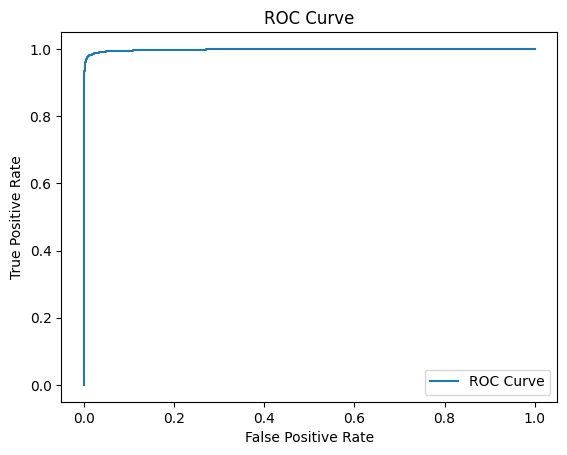

In [44]:
# test with test_loader ( 20% original data )
evaluate_model(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

Test Accuracy: 41.17%
Precision: 0.38
Recall: 0.41
F1-Score: 0.37
Confusion Matrix:
[[2039  961]
 [2569  431]]
EER: 0.54 at threshold: 0.03
AUC-ROC: 0.41


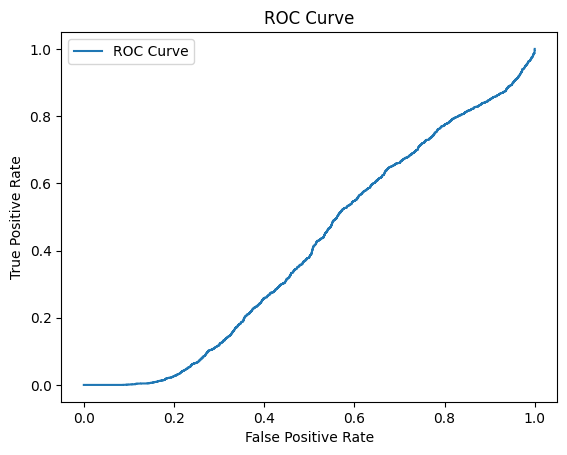

Test Accuracy: 50.83%
Precision: 0.75
Recall: 0.51
F1-Score: 0.35
Confusion Matrix:
[[3000    0]
 [2950   50]]
EER: 0.22 at threshold: 0.01
AUC-ROC: 0.86


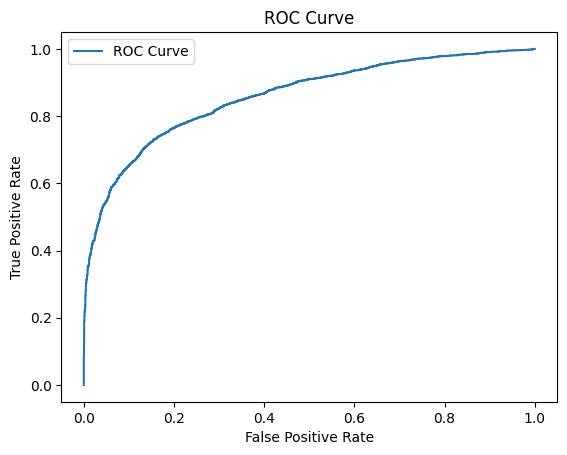

Test Accuracy: 50.08%
Precision: 0.56
Recall: 0.50
F1-Score: 0.34
Confusion Matrix:
[[2992    8]
 [2987   13]]
EER: 0.42 at threshold: 0.00
AUC-ROC: 0.62


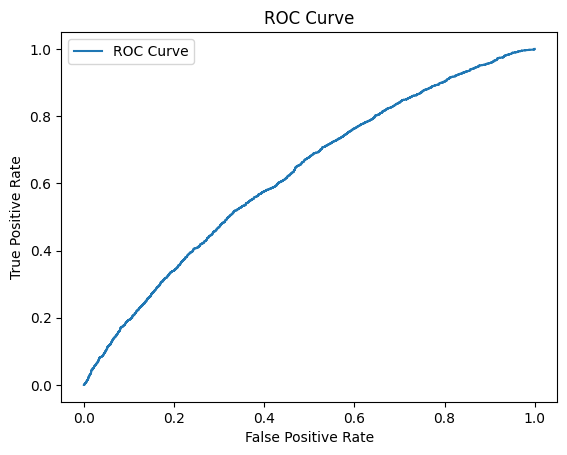

In [45]:
import os
import random
import torch
import torchaudio
import pandas as pd
from torch.utils.data import Dataset, DataLoader

class TestAudioDataset(Dataset):
    def __init__(self, bonafide_dir, spoof_dir, num_samples = 3000, transform=None):
        """
        Initialize the dataset with bonafide and spoof directories.
        
        Args:
            bonafide_dir (str): Path to the directory with bonafide audio files.
            spoof_dir (str): Path to the directory with spoofed audio files.
            transform (callable, optional): Optional transform to be applied to the audio data.
        """
        self.bonafide_dir = bonafide_dir
        self.spoof_dir = spoof_dir
        self.transform = transform
        
        # Get a list of bonafide files and spoofed files
        self.bonafide_files = [os.path.join(bonafide_dir, f) for f in os.listdir(bonafide_dir) if f.endswith('.wav')]
        self.spoof_files = [os.path.join(spoof_dir, f) for f in os.listdir(spoof_dir) if f.endswith('.wav')]

        # Randomly sample files
        self.bonafide_files = random.sample(self.bonafide_files, min(num_samples, len(self.bonafide_files)))
        self.spoof_files = random.sample(self.spoof_files, min(num_samples, len(self.spoof_files)))

        # Combine the lists and create labels
        self.audio_files = self.bonafide_files + self.spoof_files
        self.labels = [0] * len(self.bonafide_files) + [1] * len(self.spoof_files)  # 0 for bonafide, 1 for spoof

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        """
        Get a single audio sample and its corresponding label.
        
        Args:
            idx (int): Index of the sample.
        
        Returns:
            waveform (torch.Tensor): The loaded audio waveform.
            label (int): The label (1 for bonafide, 0 for spoof).
        """
        audio_path = self.audio_files[idx]
        label = self.labels[idx]

        # Load the audio waveform
        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert waveform to numpy for padding or processing if needed
        waveform = waveform.squeeze().numpy()

        # Apply any transforms if specified
        if self.transform:
            waveform = self.transform(waveform)

        return waveform, label
    
# Define the transformation pipeline
audio_transforms = transforms.Compose([
    lambda x: pad(x),        # Pad or truncate to fixed length
    lambda x: Tensor(x)      # Convert to PyTorch Tensor
])
# Example usage
bonafide_dir = "ProjectStorage/test/fmcc_bonafide_cut"  # Replace with the path to your bonafide audio directory
spoof_dir = "ProjectStorage/test/fmcc_spoofed_cut"  # Replace with the path to your spoof audio directory

fmcc_dataset = TestAudioDataset(bonafide_dir, spoof_dir, transform=audio_transforms)

# Create the DataLoader
test_fmcc_loader = DataLoader(fmcc_dataset, batch_size=32, shuffle= False)
evaluate_model(model, test_fmcc_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

## Test with jstu dataset

bonafide_dir = "ProjectStorage/test/jsut_bonafide"  # Replace with the path to your bonafide audio directory
spoof_dir = "ProjectStorage/test/jsut_spoof"  # Replace with the path to your spoof audio directory

jsut_dataset = TestAudioDataset(bonafide_dir, spoof_dir, transform=audio_transforms)

# Create the DataLoader
test_jsut_loader = DataLoader(jsut_dataset, batch_size=32, shuffle= False)
# Assuming you have the DataLoader `test_loader` and model loaded
evaluate_model(model, test_jsut_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

bonafide_dir = "ProjectStorage/test/ljspeech_bonafide_cut"  # Replace with the path to your bonafide audio directory
spoof_dir = "ProjectStorage/test/ljspeech_spoof_cut"  # Replace with the path to your spoof audio directory

ljspeech_dataset = TestAudioDataset(bonafide_dir, spoof_dir, transform=audio_transforms)

# Create the DataLoader
test_lj_loader = DataLoader(ljspeech_dataset, batch_size=32, shuffle= False)
# Assuming you have the DataLoader `test_loader` and model loaded
evaluate_model(model, test_lj_loader, device='cuda' if torch.cuda.is_available() else 'cpu')






# DAT Method

In [1]:
# Gradient Reversal Layer to reverse gradients during backprop for the domain classifier to max domain classification loss 
# allows the model to learn domain-invariant features
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import numpy as np

class GradientReversalLayer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

class GradientReversal(nn.Module):
    def __init__(self, alpha=0.1):
        super(GradientReversal, self).__init__()
        self.alpha = alpha

    def forward(self, x):
        return GradientReversalLayer.apply(x, self.alpha)

# Domain classifier which will predict the domain (different datasets) based on features extracted by the main network
class DomainClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=4):
        super(DomainClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Softmax(dim=1)  
        )

    def forward(self, x):
        return self.model(x)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import numpy as np


class SincConv(nn.Module):
    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)

    def __init__(self, device, out_channels, kernel_size, in_channels=1, sample_rate=16000,
                 stride=1, padding=0, dilation=1, bias=False, groups=1):
        super(SincConv, self).__init__()

        if in_channels != 1:
            msg = "SincConv only supports one input channel (here, in_channels = {%i})" % (in_channels)
            raise ValueError(msg)

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.sample_rate = sample_rate  # Higher sample rates can capture more detail but require more computational power.

        if kernel_size % 2 == 0:
            self.kernel_size = self.kernel_size + 1

        self.device = device
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')

        # initialize filterbanks using Mel scale
        NFFT = 512
        f = int(self.sample_rate / 2) * np.linspace(0, 1, int(NFFT / 2) + 1)
        fmel = self.to_mel(f)   # Hz to mel conversion
        fmelmax = np.max(fmel)
        fmelmin = np.min(fmel)
        filbandwidthsmel = np.linspace(fmelmin, fmelmax, self.out_channels + 1)
        filbandwidthsf = self.to_hz(filbandwidthsmel)  # Mel to Hz conversion
        self.mel = filbandwidthsf
        self.hsupp = torch.arange(-(self.kernel_size - 1) / 2, (self.kernel_size - 1) / 2 + 1)
        self.band_pass = torch.zeros(self.out_channels, self.kernel_size)

    def forward(self, x): # this method defines the forward pass of the SincConv layer 
        for i in range(len(self.mel) - 1):
            fmin = self.mel[i] # min frequency for each band-pass filter, set the smallest and largest frequencies that the filters will listen to
            fmax = self.mel[i + 1] # max freq
            hHigh = (2 * fmax / self.sample_rate) * np.sinc(2 * fmax * self.hsupp / self.sample_rate)
            hLow = (2 * fmin / self.sample_rate) * np.sinc(2 * fmin * self.hsupp / self.sample_rate)
            hideal = hHigh - hLow
            
            self.band_pass[i, :] = Tensor(np.hamming(self.kernel_size)) * Tensor(hideal) # Hamming window smooths the filters so they don’t have sharp edges, making the model perform better.

        band_pass_filter = self.band_pass.to(self.device)

        self.filters = (band_pass_filter).view(self.out_channels, 1, self.kernel_size)

        return F.conv1d(x, self.filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                        bias=None, groups=1)


class Residual_block(nn.Module):
    def __init__(self, nb_filts, first=False):
        super(Residual_block, self).__init__()
        self.first = first # indicates whether it is the first block in the model, which skips BN
        
        if not self.first:
            self.bn1 = nn.BatchNorm1d(num_features=nb_filts[0])

        self.lrelu = nn.LeakyReLU(negative_slope=0.3)

        self.conv1 = nn.Conv1d(in_channels=nb_filts[0],
                               out_channels=nb_filts[1],
                               kernel_size=3,
                               padding=1,
                               stride=1)

        self.bn2 = nn.BatchNorm1d(num_features=nb_filts[1])
        self.conv2 = nn.Conv1d(in_channels=nb_filts[1],
                               out_channels=nb_filts[1],
                               padding=1,
                               kernel_size=3,
                               stride=1)

        if nb_filts[0] != nb_filts[1]:
            self.downsample = True
            self.conv_downsample = nn.Conv1d(in_channels=nb_filts[0],
                                              out_channels=nb_filts[1],
                                              padding=0,
                                              kernel_size=1,
                                              stride=1)
        else:
            self.downsample = False

        self.mp = nn.MaxPool1d(3)

    def forward(self, x): # Adds the input (identity) to the output of the convolutional layers
        identity = x
        if not self.first:
            out = self.bn1(x)
            out = self.lrelu(out)
        else:
            out = x
            
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.lrelu(out)
        out = self.conv2(out)

        if self.downsample:
            identity = self.conv_downsample(identity)

        out += identity
        out = self.mp(out)
        return out


class RawNetWithDomainAdversarial(nn.Module):
    def __init__(self, d_args, device, alpha = 1.0):
        super(RawNetWithDomainAdversarial, self).__init__()

        self.device = device
        self.alpha = alpha  # Gradient reversal strength


        self.Sinc_conv = SincConv(device=self.device,
                                   out_channels=d_args['filts'][0],
                                   kernel_size=d_args['first_conv'],
                                   in_channels=d_args['in_channels']
                                   )

        self.first_bn = nn.BatchNorm1d(num_features=d_args['filts'][0])
        self.selu = nn.SELU(inplace=True) # Scaled Exponential Linear Unit (activation function)
        # Next, sequential blocks of residual layers, which consist of convolutional layers with skip connections to prevent vanishing gradients
        self.block0 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][1], first=True)) #[20,20]
        self.block1 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][1])) #[20,20]
        self.block2 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][2])) #[20,128]
        d_args['filts'][2][0] = d_args['filts'][2][1]
        self.block3 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][2])) #[128,128]
        self.block4 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][2])) #[128,128]
        self.block5 = nn.Sequential(Residual_block(nb_filts=d_args['filts'][2])) #[128,128]
        self.avgpool = nn.AdaptiveAvgPool1d(1) # Average over time, create a summary of the feature map

        # Attention FC layers compute attention weights for each residual block. Highlight important parts of the feature maps
        self.fc_attention0 = self._make_attention_fc(in_features=d_args['filts'][1][-1],
                                                     l_out_features=d_args['filts'][1][-1])
        self.fc_attention1 = self._make_attention_fc(in_features=d_args['filts'][1][-1],
                                                     l_out_features=d_args['filts'][1][-1])
        self.fc_attention2 = self._make_attention_fc(in_features=d_args['filts'][2][-1],
                                                     l_out_features=d_args['filts'][2][-1])
        self.fc_attention3 = self._make_attention_fc(in_features=d_args['filts'][2][-1],
                                                     l_out_features=d_args['filts'][2][-1])
        self.fc_attention4 = self._make_attention_fc(in_features=d_args['filts'][2][-1],
                                                     l_out_features=d_args['filts'][2][-1])
        self.fc_attention5 = self._make_attention_fc(in_features=d_args['filts'][2][-1],
                                                     l_out_features=d_args['filts'][2][-1])

        self.bn_before_gru = nn.BatchNorm1d(num_features=d_args['filts'][2][-1])
        
        self.gru = nn.GRU(input_size=d_args['filts'][2][-1],
                          hidden_size=d_args['gru_node'],
                          num_layers=d_args['nb_gru_layer'],
                          batch_first=True)

        self.fc1_gru = nn.Linear(in_features=d_args['gru_node'],
                                  out_features=d_args['nb_fc_node'])

        self.fc2_gru = nn.Linear(in_features=d_args['nb_fc_node'],
                                  out_features=d_args['nb_classes'], bias=True)

        # Domain-Adversarial Components
        self.gradient_reversal = GradientReversal(alpha=self.alpha)
        self.domain_classifier = DomainClassifier(input_dim=d_args['gru_node'])

        self.sig = nn.Sigmoid()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, y=None, return_domain=False):
        nb_samp = x.shape[0]
        len_seq = x.shape[1]
        x = x.view(nb_samp, 1, len_seq)

        x = self.Sinc_conv(x)
        x = F.max_pool1d(torch.abs(x), 3)
        x = self.first_bn(x)
        x = self.selu(x)

        x0 = self.block0(x)
        y0 = self.avgpool(x0).view(x0.size(0), -1)  # torch.Size([batch, filter])
        y0 = self.fc_attention0(y0)
        y0 = self.sig(y0).view(y0.size(0), y0.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x0 * y0 + y0  # (batch, filter, time) x (batch, filter, 1)

        x1 = self.block1(x)
        y1 = self.avgpool(x1).view(x1.size(0), -1)  # torch.Size([batch, filter])
        y1 = self.fc_attention1(y1)
        y1 = self.sig(y1).view(y1.size(0), y1.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x1 * y1 + y1  # (batch, filter, time) x (batch, filter, 1)

        x2 = self.block2(x)
        y2 = self.avgpool(x2).view(x2.size(0), -1)  # torch.Size([batch, filter])
        y2 = self.fc_attention2(y2)
        y2 = self.sig(y2).view(y2.size(0), y2.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x2 * y2 + y2  # (batch, filter, time) x (batch, filter, 1)

        x3 = self.block3(x)
        y3 = self.avgpool(x3).view(x3.size(0), -1)  # torch.Size([batch, filter])
        y3 = self.fc_attention3(y3)
        y3 = self.sig(y3).view(y3.size(0), y3.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x3 * y3 + y3  # (batch, filter, time) x (batch, filter, 1)

        x4 = self.block4(x)
        y4 = self.avgpool(x4).view(x4.size(0), -1)  # torch.Size([batch, filter])
        y4 = self.fc_attention4(y4)
        y4 = self.sig(y4).view(y4.size(0), y4.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x4 * y4 + y4  # (batch, filter, time) x (batch, filter, 1)

        x5 = self.block5(x)
        y5 = self.avgpool(x5).view(x5.size(0), -1)  # torch.Size([batch, filter])
        y5 = self.fc_attention5(y5)
        y5 = self.sig(y5).view(y5.size(0), y5.size(1), -1)  # torch.Size([batch, filter, 1])
        x = x5 * y5 + y5  # (batch, filter, time) x (batch, filter, 1)

        x = self.bn_before_gru(x)

        x = x.transpose(1, 2)
        x, _ = self.gru(x)  # return only hidden states of last layer
        x = x[:, -1, :]  # (batch, seq_len, hidden_size)
        
        # Primary task (e.g., classification)
        primary_output = self.fc1_gru(x)
        primary_output = self.fc2_gru(primary_output)

        if return_domain:
            # Domain-Adversarial branch
            reversed_features = self.gradient_reversal(x)
            domain_output = self.domain_classifier(reversed_features)
            return primary_output, domain_output
        else: return primary_output
        

        

    def _make_attention_fc(self, in_features, l_out_features):
        l_fc = []
        l_fc.append(nn.Linear(in_features = in_features,
                    out_features = l_out_features))
        return nn.Sequential(*l_fc)
    def _make_layer(self, nb_blocks, nb_filts, first = False):
        layers = []
        #def __init__(self, nb_filts, first = False):
        for i in range(nb_blocks):
            first = first if i == 0 else False
            layers.append(Residual_block(nb_filts = nb_filts,
                first = first))
            if i == 0: nb_filts[0] = nb_filts[1]
            
        return nn.Sequential(*layers)

    def summary(self, input_size, batch_size=-1, device="cuda", print_fn = None):
        if print_fn == None: printfn = print
        model = self
        
        def register_hook(module):
            def hook(module, input, output):
                class_name = str(module.__class__).split(".")[-1].split("'")[0]
                module_idx = len(summary)
                
                m_key = "%s-%i" % (class_name, module_idx + 1)
                summary[m_key] = OrderedDict()
                summary[m_key]["input_shape"] = list(input[0].size())
                summary[m_key]["input_shape"][0] = batch_size
                if isinstance(output, (list, tuple)):
                    summary[m_key]["output_shape"] = [
						[-1] + list(o.size())[1:] for o in output
					]
                else:
                    summary[m_key]["output_shape"] = list(output.size())
                    if len(summary[m_key]["output_shape"]) != 0:
                        summary[m_key]["output_shape"][0] = batch_size
                        
                params = 0
                if hasattr(module, "weight") and hasattr(module.weight, "size"):
                    params += torch.prod(torch.LongTensor(list(module.weight.size())))
                    summary[m_key]["trainable"] = module.weight.requires_grad
                if hasattr(module, "bias") and hasattr(module.bias, "size"):
                    params += torch.prod(torch.LongTensor(list(module.bias.size())))
                summary[m_key]["nb_params"] = params
                
            if (
				not isinstance(module, nn.Sequential)
				and not isinstance(module, nn.ModuleList)
				and not (module == model)
			):
                hooks.append(module.register_forward_hook(hook))
                
        device = device.lower()
        assert device in [
			"cuda",
			"cpu",
		], "Input device is not valid, please specify 'cuda' or 'cpu'"
        
        if device == "cuda" and torch.cuda.is_available():
            dtype = torch.cuda.FloatTensor
        else:
            dtype = torch.FloatTensor
        if isinstance(input_size, tuple):
            input_size = [input_size]
        x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]
        summary = OrderedDict()
        hooks = []
        model.apply(register_hook)
        model(*x)
        for h in hooks:
            h.remove()
            
        print_fn("----------------------------------------------------------------")
        line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
        print_fn(line_new)
        print_fn("================================================================")
        total_params = 0
        total_output = 0
        trainable_params = 0
        for layer in summary:
            # input_shape, output_shape, trainable, nb_params
            line_new = "{:>20}  {:>25} {:>15}".format(
				layer,
				str(summary[layer]["output_shape"]),
				"{0:,}".format(summary[layer]["nb_params"]),
			)
            total_params += summary[layer]["nb_params"]
            total_output += np.prod(summary[layer]["output_shape"])
            if "trainable" in summary[layer]:
                if summary[layer]["trainable"] == True:
                    trainable_params += summary[layer]["nb_params"]
            print_fn(line_new)



In [2]:
import os
import torch
import numpy as np
import torchaudio
import pandas as pd
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, random_split,ConcatDataset
from torchvision import transforms
from sklearn.model_selection import train_test_split

# Define the pad function to ensure fixed input size
def pad(x, max_len=64600):
    x_len = x.shape[0]
    if x_len >= max_len:
        return x[:max_len]
    # Need to pad
    num_repeats = int(max_len / x_len) + 1
    padded_x = np.tile(x, (1, num_repeats))[:, :max_len][0]
    return padded_x

# Define a custom dataset for loading your audio files and labels
class AudioDataset(Dataset):
    def __init__(self, audio_dir, meta_file, transform=None):
        self.audio_dir = audio_dir
        self.transform = transform

        # Load the meta CSV file containing labels
        self.meta_data = pd.read_csv(meta_file)

        # Create a dictionary of filenames to labels
        self.audio_labels = dict(zip(self.meta_data['file'], self.meta_data['label']))
        
        # Get the list of audio files in the directory
        self.audio_files = [f for f in os.listdir(audio_dir) if f in self.audio_labels]  # Only files with labels

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        # Get the filename and corresponding label
        audio_filename = self.audio_files[idx]
        label = self.audio_labels[audio_filename]
        
        # Load the audio waveform
        audio_path = os.path.join(self.audio_dir, audio_filename)
        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert to numpy array for padding
        waveform = waveform.squeeze().numpy()

        if self.transform:
            waveform = self.transform(waveform)

        # Convert label to a numerical format: 0 for 'spoof', 1 for 'bona-fide'
        label = 1 if label == 'spoof' else 0

        return waveform, label

# Define a custom dataset for loading your audio files and labels
class OriDomainAudioDataset(Dataset):
    def __init__(self, audio_dir, meta_file, transform=None, domain = 0):
        self.audio_dir = audio_dir
        self.transform = transform
        self.domain_labels = domain
        
        # Load the meta CSV file containing labels
        self.meta_data = pd.read_csv(meta_file)

        # Create a dictionary of filenames to labels
        self.audio_labels = dict(zip(self.meta_data['file'], self.meta_data['label']))
        
        # Get the list of audio files in the directory
        self.audio_files = [f for f in os.listdir(audio_dir) if f in self.audio_labels]  # Only files with labels

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        # Get the filename and corresponding label
        audio_filename = self.audio_files[idx]
        label = self.audio_labels[audio_filename]
        
        # Load the audio waveform
        audio_path = os.path.join(self.audio_dir, audio_filename)
        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert to numpy array for padding
        waveform = waveform.squeeze().numpy()

        if self.transform:
            waveform = self.transform(waveform)

        # Convert label to a numerical format: 0 for 'spoof', 1 for 'bona-fide'
        label = 1 if label == 'spoof' else 0

        return waveform, label, self.domain_labels


class OriDomainAugmentedAudioDataset(Dataset):
    def __init__(self, audio_dir, meta_file, transform=None, domain = 0):
        self.audio_dir = audio_dir
        self.transform = transform
        self.domain_labels = domain

        # Load the metadata CSV and map file numbers to labels
        self.meta_data = pd.read_csv(meta_file)
        # Extract numeric part and create a mapping for labels
        self.audio_labels = dict(zip(self.meta_data['file'], self.meta_data['label']))

        # Filter audio files in the directory to match only those with "augmented_" prefix
        self.audio_files = [f for f in os.listdir(audio_dir) if ".wav" in f]

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        # Get the augmented file name
        audio_filename = self.audio_files[idx]
        
        # Extract the original file number from the augmented file name
        file_name = audio_filename.split('_')[-1]

        # Retrieve label using the extracted file number
        label = self.audio_labels.get(file_name, 'unknown')
        
        # Load the audio waveform
        audio_path = os.path.join(self.audio_dir, audio_filename)
        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert to numpy array for padding
        waveform = waveform.squeeze().numpy()

        # Apply transformations if any
        if self.transform:
            waveform = self.transform(waveform)

        # Convert label to numerical format: 0 for 'bonafide', 1 for 'spoof'
        label = 1 if label == 'spoof' else 0

        return waveform, label, self.domain_labels

# Define the transformation pipeline
audio_transforms = transforms.Compose([
    lambda x: pad(x),        # Pad or truncate to fixed length
    lambda x: Tensor(x)      # Convert to PyTorch Tensor
])



In [3]:


# Path to the directory containing the audio files and the CSV file
train_audio_dir = 'ProjectStorage/wav_train_set'
val_audio_dir = 'ProjectStorage/wav_val_set'
test_audio_dir = 'ProjectStorage/wav_test_set'
augmented_dir = 'ProjectStorage/augmented_audio_files'

meta_file = 'ProjectStorage/meta.csv'

# Initialize the dataset with labels
train_dataset = OriDomainAudioDataset(audio_dir=train_audio_dir, meta_file=meta_file, transform=audio_transforms)
val_dataset = OriDomainAudioDataset(audio_dir=val_audio_dir, meta_file=meta_file, transform=audio_transforms)
test_dataset = AudioDataset(audio_dir=test_audio_dir, meta_file=meta_file, transform=audio_transforms)
augmented_dataset = OriDomainAugmentedAudioDataset(audio_dir=augmented_dir, meta_file=meta_file, transform=audio_transforms)


combined_train_dataset = ConcatDataset([train_dataset, augmented_dataset])

# Print dataset sizes
print("Training set size:", len(combined_train_dataset))
print("Validation set size:", len(val_dataset))
print("Test set size:", len(test_dataset))



Training set size: 54015
Validation set size: 3178
Test set size: 6356


In [4]:
print("Test set size:", len(test_dataset))

Test set size: 6356


In [5]:
print("Domain labels in dataset:", augmented_dataset.domain_labels)

Domain labels in dataset: 0


In [6]:
# Process external datasets for training
import os
import random
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class DomainAudioDataset(Dataset):
    def __init__(self, domain_dirs, labels, domain_labels, num_samples=500, transform=None, reserve_unsampled=True):
        """
        Initialize the dataset with multiple domains, tracking unsampled files.
        
        Args:
            domain_dirs (dict): Dictionary where keys are domain names and values are tuples 
                                of (bonafide_dir, spoof_dir) for each domain.
            labels (dict): Dictionary where keys are domain names and values are lists of [0, 1] 
                           (0 = bonafide, 1 = spoof).
            domain_labels (dict): Dictionary where keys are domain names and values are unique 
                                  integer labels for each domain.
            num_samples (int): Number of samples per domain to load.
            transform (callable, optional): Optional transform to be applied to the audio data.
            reserve_unsampled (bool): Whether to keep track of unsampled data for evaluation.
        """
        self.transform = transform
        self.audio_files = []
        self.labels = []
        self.domain_labels = []
        self.unsampled_data = {} if reserve_unsampled else None  # Store unsampled data if required

        # Iterate over each domain directory
        for domain, (bonafide_dir, spoof_dir) in domain_dirs.items():
            # Bonafide and spoof files
            bonafide_files = [os.path.join(bonafide_dir, f) for f in os.listdir(bonafide_dir) if f.endswith('.wav')]
            spoof_files = [os.path.join(spoof_dir, f) for f in os.listdir(spoof_dir) if f.endswith('.wav')]

            # Randomly sample files for training
            sampled_bonafide = random.sample(bonafide_files, min(num_samples, len(bonafide_files)))
            sampled_spoof = random.sample(spoof_files, min(num_samples, len(spoof_files)))

            # Track unsampled data for evaluation
            if reserve_unsampled:
                unsampled_bonafide = list(set(bonafide_files) - set(sampled_bonafide))
                unsampled_spoof = list(set(spoof_files) - set(sampled_spoof))
                self.unsampled_data[domain] = {
                    "bonafide": unsampled_bonafide,
                    "spoof": unsampled_spoof
                }

            # Add to training data lists
            self.audio_files += sampled_bonafide + sampled_spoof
            self.labels += [0] * len(sampled_bonafide) + [1] * len(sampled_spoof)
            self.domain_labels += [domain_labels[domain]] * (len(sampled_bonafide) + len(sampled_spoof))

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_path = self.audio_files[idx]
        label = self.labels[idx]
        domain_label = self.domain_labels[idx]

        # Load audio
        waveform, sample_rate = torchaudio.load(audio_path)
        waveform = waveform.squeeze().numpy()  # Convert to numpy

        # Apply transformations
        if self.transform:
            waveform = self.transform(waveform)

        return torch.tensor(waveform), label, domain_label

# Define transformation
audio_transforms = transforms.Compose([
    lambda x: pad(x),  # Replace with actual padding function
    lambda x: torch.tensor(x)
])

# Define directories and labels
domain_dirs = {
    'fmcc': ("ProjectStorage/test/fmcc_bonafide_cut", "ProjectStorage/test/fmcc_spoofed_cut"),
    'jsut': ("ProjectStorage/test/jsut_bonafide", "ProjectStorage/test/jsut_spoof"),
    'ljspeech': ("ProjectStorage/test/ljspeech_bonafide_cut", "ProjectStorage/test/ljspeech_spoof_cut")
}
domain_labels = {'fmcc': 1, 'jsut': 2, 'ljspeech': 3}

# Create the training dataset with reserved unsampled data for evaluation
train_val_dataset = DomainAudioDataset(domain_dirs, labels={'bonafide': 0, 'spoof': 1}, domain_labels=domain_labels, transform=audio_transforms)

# Define the split sizes
train_size = int(0.8 * len(train_val_dataset))  # 80% for training
val_size = len(train_val_dataset) - train_size  

# Split the dataset
ext_train_dataset, ext_val_dataset = random_split(train_val_dataset, [train_size, val_size])



# Extract unsampled data for testing
unsampled_data = train_val_dataset.unsampled_data

# Create DataLoaders for each domain's unsampled test data
def create_test_loader(domain, unsampled_data, transform=None, batch_size=32):
    audio_files = unsampled_data[domain]["bonafide"] + unsampled_data[domain]["spoof"]
    labels = [0] * len(unsampled_data[domain]["bonafide"]) + [1] * len(unsampled_data[domain]["spoof"])

    # Custom dataset for unsampled test data
    class TestDataset(Dataset):
        def __init__(self, audio_files, labels, transform):
            self.audio_files = audio_files
            self.labels = labels
            self.transform = transform

        def __len__(self):
            return len(self.audio_files)

        def __getitem__(self, idx):
            audio_path = self.audio_files[idx]
            label = self.labels[idx]
            waveform, _ = torchaudio.load(audio_path)
            waveform = waveform.squeeze().numpy()
            if self.transform:
                waveform = self.transform(waveform)
            return torch.tensor(waveform), label

    test_dataset = TestDataset(audio_files, labels, transform)
    return DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [7]:
# Print dataset sizes
print("Ext Training set size:", len(ext_train_dataset))
print("Ext Validation set size:", len(ext_val_dataset))


Ext Training set size: 2400
Ext Validation set size: 600


In [8]:
print("Domain labels in dataset:", set(train_val_dataset.domain_labels))

Domain labels in dataset: {1, 2, 3}


In [9]:
# Combine training datasets and load using DataLoader
final_train_dataset = ConcatDataset([combined_train_dataset, ext_train_dataset])
print("Final Training set size:", len(final_train_dataset))
# DataLoader for training
train_loader = DataLoader(final_train_dataset, batch_size=32, shuffle=True)

# Combine training datasets and load using DataLoader
final_val_dataset = ConcatDataset([val_dataset, ext_val_dataset])
print("Final Validation set size:", len(final_val_dataset))
val_loader = DataLoader(final_val_dataset, batch_size=32, shuffle=False)

# Create DataLoaders for each domain's unsampled test data
ext_test_loaders = {domain: create_test_loader(domain, unsampled_data, transform=audio_transforms) for domain in unsampled_data}


Final Training set size: 56415
Final Validation set size: 3778


In [10]:
from collections import Counter

# Function to calculate label distribution
def get_label_distribution(dataset):
    labels = []
    for data in dataset:
        # Check the number of inputs in the tuple
        if len(data) == 3:
            _, label, _ = data  # Unpack when there are three inputs
        elif len(data) == 2:
            _, label = data  # Unpack when there are two inputs
        labels.append(label)  # Append the label to the list

    # Count occurrences of each label
    label_counts = Counter(labels)
    total = sum(label_counts.values())
    
    # Calculate distribution
    distribution = {k: v / total for k, v in label_counts.items()}
    
    return label_counts, distribution

# Calculate label distribution for each dataset
train_counts, train_distribution = get_label_distribution(final_train_dataset)
val_counts, val_distribution = get_label_distribution(final_val_dataset)

# Print the results
print("Training set size:", len(final_train_dataset))
print("Training set label counts:", train_counts)
print("Training set label distribution:", train_distribution)

print("\nValidation set size:", len(final_val_dataset))
print("Validation set label counts:", val_counts)
print("Validation set label distribution:", val_distribution)


/tmp/ipykernel_1673932/2443862127.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(waveform), label, domain_label


Training set size: 56415
Training set label counts: Counter({0: 35093, 1: 21322})
Training set label distribution: {1: 0.3779491270052291, 0: 0.6220508729947709}

Validation set size: 3778
Validation set label counts: Counter({0: 2289, 1: 1489})
Validation set label distribution: {0: 0.6058761249338275, 1: 0.3941238750661726}


In [11]:
device = torch.device('cuda')

d_args = {
    'in_channels': 1,          # For mono audio; set to 2 for stereo
    'first_conv': 1024,         # Adjust this based on your audio length
    'filts': [20, [20,20], [20,128],[128,128]],  # These can be adjusted
    'blocks': [2,4],
    'gru_node': 1024,           # Number of GRU units
    'nb_gru_layer': 3,         # Number of GRU layers
    'nb_fc_node': 1024,         # Number of units in the fully connected layer
    'nb_classes': 2           # Change this to the number of classes in your dataset
}

model= RawNetWithDomainAdversarial(d_args, device).to(device)

In [12]:
import torch
print(torch.cuda.is_available())


True


In [13]:
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import roc_curve
from torch import nn

#import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Class weights for the label classifier (do not normalize if using class frequencies)
label_criterion = nn.CrossEntropyLoss()  
domain_criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 20
early_stopping_patience = 3
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4)
best_val_loss = float('inf')

# EER Calculation Function
def calculate_eer(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
    eer = fnr[np.nanargmin(np.abs(fnr - fpr))]
    return eer, eer_threshold

# Training Loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0.0  # Initialize variable to accumulate loss
    domain_epoch_loss = 0.0  # Initialize variable for domain loss
    total_correct = 0  # Initialize variable to count correct predictions
    total_samples = 0  # Initialize variable to count total samples

    for inputs, labels, domain_labels in train_loader:  # Assuming domain_labels is provided
        
        inputs, labels, domain_labels = inputs.to(device), labels.to(device), domain_labels.to(device)
        #print("Domain labels:", domain_labels)
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass through the model
        outputs, domain_outputs = model(inputs, return_domain=True)  
        # Check tensor sizes
        #print(f"Outputs shape: {outputs.shape}, Domain Outputs shape: {domain_outputs.shape}, Label shape: {labels.shape}, Domain Label shape: {domain_labels.shape}")  # Check shapes
        

        
        num_classes = 2
        # # Check labels for label loss
        # print("Checking `labels` for label loss:")
        # print("Unique values:", labels.unique())
        # print("Data type:", labels.dtype)
        # print("Min value:", labels.min().item(), "Max value:", labels.max().item())
        # assert labels.dtype == torch.long, "Labels must be of type `torch.long`"
        # assert labels.min().item() >= 0 and labels.max().item() < num_classes, f"Labels must be in range [0, {num_classes - 1}]"
        # num_domains = 4
        # # Check domain_labels for domain loss
        # print("Checking `domain_labels` for domain loss:")
        # print("Unique values:", domain_labels.unique())
        # print("Data type:", domain_labels.dtype)
        # print("Min value:", domain_labels.min().item(), "Max value:", domain_labels.max().item())
        # assert domain_labels.dtype == torch.long, "Domain labels must be of type `torch.long`"
        # assert domain_labels.min().item() >= 0 and domain_labels.max().item() < num_domains, f"Domain labels must be in range [0, {num_domains - 1}]"
        
        
        # Calculate losses
        label_loss = label_criterion(outputs, labels)  # Loss for label classifier
        domain_loss = domain_criterion(domain_outputs, domain_labels)  # Loss for domain classifier

        lambda_value = 0.4
        # Minimize label loss and maximize domain loss
        total_loss = label_loss - lambda_value * domain_loss
        total_loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        # Accumulate loss and calculate accuracy
        epoch_loss += label_loss.item()  # Only accumulate label loss for reporting
        domain_epoch_loss += domain_loss.item()  # Accumulate domain loss separately
        _, predicted = torch.max(outputs, 1)  # Get the predicted class
        total_correct += (predicted == labels).sum().item()  # Count correct predictions
        total_samples += labels.size(0)  # Count total samples

    # Calculate average losses and accuracy for the epoch
    avg_loss = epoch_loss / len(train_loader)
    avg_domain_loss = domain_epoch_loss / len(train_loader)
    accuracy = total_correct / total_samples * 100  # Convert to percentage
    print(f'Epoch [{epoch + 1}/{num_epochs}], Label Loss: {avg_loss:.4f}, Domain Loss: {avg_domain_loss:.4f}, Accuracy: {accuracy:.2f}%')

    # Validation Loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_samples = 0
    all_labels = []
    all_scores = []

    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, labels, domain_labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device) 
    
            # Assume the second element of the tuple in val_loader is ignored (domain_labels)
            outputs = model(inputs)  # Forward pass
            loss = label_criterion(outputs, labels)  # Calculate loss for validation

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            val_correct += (predicted == labels).sum().item()  # Count correct predictions
            val_samples += labels.size(0)  # Count total samples
            
            # Collect scores for EER calculation
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(outputs[:, 1].cpu().numpy())  # Scores for the positive class

    # Calculate EER using collected labels and scores
    eer, eer_threshold = calculate_eer(np.array(all_labels), np.array(all_scores))

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_samples * 100  # Convert to percentage
    print(f'Validation - Average Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%, EER: {eer:.4f}')

    # Adjust learning rate based on validation loss
    scheduler.step(avg_val_loss)

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0  # Reset counter when we get a new best validation loss
        # Optionally save the model: torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break  # Stop training if no improvement after `patience` epochs


OutOfMemoryError: CUDA out of memory. Tried to allocate 38.00 MiB. GPU 0 has a total capacity of 15.77 GiB of which 10.88 MiB is free. Process 1670584 has 14.74 GiB memory in use. Including non-PyTorch memory, this process has 1.01 GiB memory in use. Of the allocated memory 641.92 MiB is allocated by PyTorch, and 18.08 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

##lambda value = 0.2

Epoch [1/20], Label Loss: 0.6722, Domain Loss: 185.1691, Accuracy: 60.31%
Validation - Average Loss: 0.6836, Accuracy: 60.06%, EER: 0.4685
/tmp/ipykernel_1427116/2443862127.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(waveform), label, domain_label
Epoch [2/20], Label Loss: 0.6691, Domain Loss: 860.0245, Accuracy: 61.29%
Validation - Average Loss: 0.6808, Accuracy: 60.06%, EER: 0.4858
/tmp/ipykernel_1427116/2443862127.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(waveform), label, domain_label
Epoch [3/20], Label Loss: 0.6751, Domain Loss: 2223.7692, Accuracy: 61.15%
Validation - Average Loss: 0.7053, Accuracy: 60.06%, EER: 0.5056
/tmp/ipykernel_1427116/2443862127.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(waveform), label, domain_label
Epoch [4/20], Label Loss: 0.6698, Domain Loss: 11864.3432, Accuracy: 61.65%
Validation - Average Loss: 0.6761, Accuracy: 60.06%, EER: 0.4950
/tmp/ipykernel_1427116/2443862127.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(waveform), label, domain_label
Epoch [5/20], Label Loss: 0.6598, Domain Loss: 5838.7993, Accuracy: 61.34%
Validation - Average Loss: 0.6633, Accuracy: 60.06%, EER: 0.3970
/tmp/ipykernel_1427116/2443862127.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(waveform), label, domain_label
Epoch [6/20], Label Loss: 0.6432, Domain Loss: 19.2902, Accuracy: 61.74%
Validation - Average Loss: 0.6632, Accuracy: 58.10%, EER: 0.3559
/tmp/ipykernel_1427116/2443862127.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(waveform), label, domain_label
Epoch [7/20], Label Loss: 0.6373, Domain Loss: 22.7381, Accuracy: 62.09%
Validation - Average Loss: 0.6288, Accuracy: 61.20%, EER: 0.3585
/tmp/ipykernel_1427116/2443862127.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(waveform), label, domain_label
Epoch [8/20], Label Loss: 0.6308, Domain Loss: 26.1865, Accuracy: 62.90%
Validation - Average Loss: 0.6306, Accuracy: 62.28%, EER: 0.3744
/tmp/ipykernel_1427116/2443862127.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(waveform), label, domain_label
Epoch [9/20], Label Loss: 0.6062, Domain Loss: 29.6414, Accuracy: 65.48%
Validation - Average Loss: 0.5393, Accuracy: 71.73%, EER: 0.2836
/tmp/ipykernel_1427116/2443862127.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(waveform), label, domain_label
Epoch [10/20], Label Loss: 0.5676, Domain Loss: 33.1114, Accuracy: 69.79%
Validation - Average Loss: 0.6131, Accuracy: 65.83%, EER: 0.3486
/tmp/ipykernel_1427116/2443862127.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(waveform), label, domain_label
Epoch [11/20], Label Loss: 0.5302, Domain Loss: 36.5259, Accuracy: 73.29%
Validation - Average Loss: 0.4815, Accuracy: 77.08%, EER: 0.2319
/tmp/ipykernel_1427116/2443862127.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(waveform), label, domain_label
Epoch [12/20], Label Loss: 0.4323, Domain Loss: 39.9717, Accuracy: 80.27%
Validation - Average Loss: 0.4310, Accuracy: 80.17%, EER: 0.1935
/tmp/ipykernel_1427116/2443862127.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(waveform), label, domain_label
Epoch [13/20], Label Loss: 0.4184, Domain Loss: 43.4234, Accuracy: 81.44%
Validation - Average Loss: 0.3344, Accuracy: 86.79%, EER: 0.1279
/tmp/ipykernel_1427116/2443862127.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(waveform), label, domain_label
Epoch [14/20], Label Loss: 0.5133, Domain Loss: 3543.7598, Accuracy: 73.06%
Validation - Average Loss: 0.6747, Accuracy: 60.06%, EER: 0.5202
/tmp/ipykernel_1427116/2443862127.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(waveform), label, domain_label
Epoch [15/20], Label Loss: 0.6723, Domain Loss: 19902.3477, Accuracy: 61.65%
Validation - Average Loss: 0.6769, Accuracy: 60.06%, EER: 0.7568
/tmp/ipykernel_1427116/2443862127.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(waveform), label, domain_label
Epoch [16/20], Label Loss: 0.6718, Domain Loss: 21860.1273, Accuracy: 61.16%
Validation - Average Loss: 0.6779, Accuracy: 60.06%, EER: 0.5606
Early stopping triggered

In [ ]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Assuming `model` is your trained RawNet model and `test_loader` is your DataLoader for the test set
def evaluate_model(model, test_loader, device):
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track performance metrics
    all_labels = []
    all_predictions = []
    all_probs = []  # For ROC-AUC or EER if needed
    
    # Disable gradient computation
    with torch.no_grad():
        for data, labels in test_loader:
            # Move data to the appropriate device (GPU/CPU)
            data, labels = data.to(device), labels.to(device)

            # Forward pass: Get model predictions
            outputs = model(data)
            
            # Get the predicted class (highest score in the output)
            _, predicted = torch.max(outputs, dim=1)
            
            # Store labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            
            # Store probabilities for ROC-AUC/EER if needed
            probs = torch.softmax(outputs, dim=1)  # Probability distribution
            all_probs.extend(probs[:, 1].cpu().numpy())  # Assuming binary classification
            
    # Convert lists to numpy arrays for metric calculation
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probs = np.array(all_probs)

    # Calculate Accuracy
    accuracy = np.mean(all_predictions == all_labels) * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Calculate Precision, Recall, and F1-Score (binary or multi-class)
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    print(f"Confusion Matrix:\n{conf_matrix}")
    # Calculate EER
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    fnr = 1 - tpr  # False Negative Rate
    eer_index = np.nanargmin(np.abs(fnr - fpr))  # Find index where FNR = FPR
    eer = fpr[eer_index]  # EER value
    eer_threshold = thresholds[eer_index]  # EER threshold
    print(f"EER: {eer:.2f} at threshold: {eer_threshold:.2f}")

    # ROC-AUC (for binary classification)
    if len(np.unique(all_labels)) == 2:  # Only for binary classification
        auc_roc = roc_auc_score(all_labels, all_probs)
        print(f"AUC-ROC: {auc_roc:.2f}")
        
        # Optionally, plot the ROC curve
        fpr, tpr, _ = roc_curve(all_labels, all_probs)
        plt.plot(fpr, tpr, label='ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()
        
        

Test Accuracy: 63.58%
Precision: 0.40
Recall: 0.64
F1-Score: 0.49
Confusion Matrix:
[[4041    0]
 [2315    0]]
EER: 0.46 at threshold: 0.44
AUC-ROC: 0.53


/home/ubuntu/studies/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


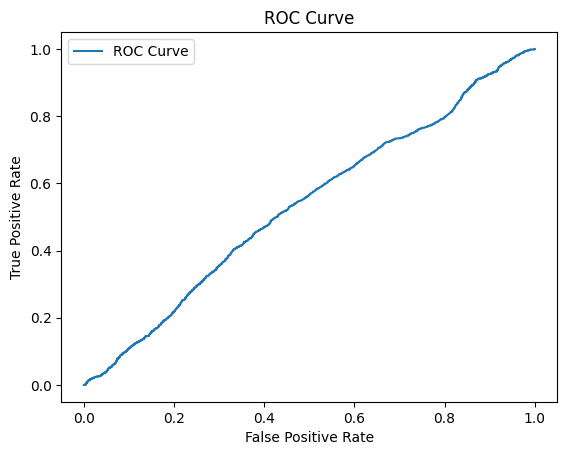

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
evaluate_model(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, device):
    model.eval()

    all_labels = []
    all_predictions = []
    all_probs = []
    
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs[:, 1].cpu().numpy())

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probs = np.array(all_probs)

    accuracy = np.mean(all_predictions == all_labels) * 100
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    fnr = 1 - tpr
    eer_index = np.nanargmin(np.abs(fnr - fpr))
    eer = fpr[eer_index]
    eer_threshold = thresholds[eer_index]
    
    if len(np.unique(all_labels)) == 2:
        auc_roc = roc_auc_score(all_labels, all_probs)
    else:
        auc_roc = None  # AUC-ROC is not applicable for multi-class

    # Optionally plot ROC curve
    if auc_roc is not None:
        plt.plot(fpr, tpr, label='ROC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

    # Return the metrics as a dictionary along with predictions and labels
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix,
        'eer': eer,
        'eer_threshold': eer_threshold,
        'auc_roc': auc_roc,
        'predictions': all_predictions,
        'labels': all_labels
    }


Evaluating model on domain: fmcc


/tmp/ipykernel_1427116/2443862127.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(waveform), label
/home/ubuntu/studies/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


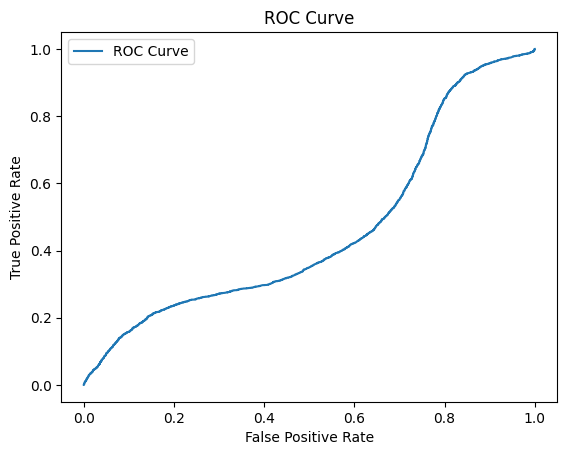

/tmp/ipykernel_1427116/2443862127.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(waveform), label


Evaluating model on domain: jsut


/home/ubuntu/studies/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


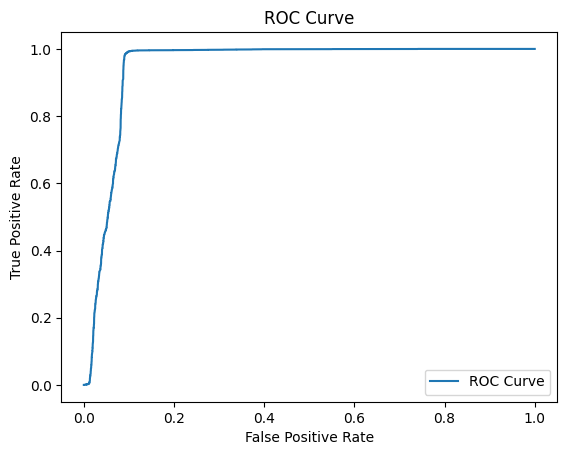

Evaluating model on domain: ljspeech


/tmp/ipykernel_1427116/2443862127.py:124: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(waveform), label
/home/ubuntu/studies/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


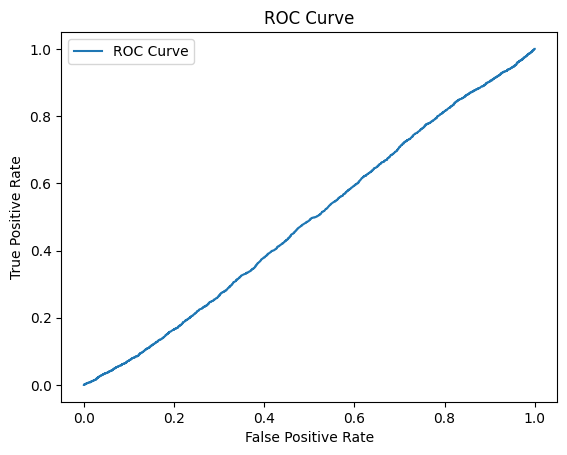

{'fmcc': {'accuracy': 50.0, 'precision': 0.25, 'recall': 0.5, 'f1_score': 0.3333333333333333, 'confusion_matrix': array([[4500,    0],
       [4500,    0]]), 'eer': 0.5877777777777777, 'eer_threshold': 0.43662378, 'auc_roc': 0.460278962962963, 'predictions': array([0, 0, 0, ..., 0, 0, 0]), 'labels': array([0, 0, 0, ..., 1, 1, 1])}, 'jsut': {'accuracy': 50.0, 'precision': 0.25, 'recall': 0.5, 'f1_score': 0.3333333333333333, 'confusion_matrix': array([[4500,    0],
       [4500,    0]]), 'eer': 0.08733333333333333, 'eer_threshold': 0.43665165, 'auc_roc': 0.9460915308641977, 'predictions': array([0, 0, 0, ..., 0, 0, 0]), 'labels': array([0, 0, 0, ..., 1, 1, 1])}, 'ljspeech': {'accuracy': 50.0, 'precision': 0.25, 'recall': 0.5, 'f1_score': 0.3333333333333333, 'confusion_matrix': array([[5500,    0],
       [5500,    0]]), 'eer': 0.5045454545454545, 'eer_threshold': 0.43664932, 'auc_roc': 0.4885266446280992, 'predictions': array([0, 0, 0, ..., 0, 0, 0]), 'labels': array([0, 0, 0, ..., 1, 1,

In [ ]:
results = {}  # Dictionary to store results for each domain

for domain, test_loader in ext_test_loaders.items():
    print(f"Evaluating model on domain: {domain}")
    metrics = evaluate_model(model, test_loader, device)  # Get metrics
    results[domain] = metrics  # Store metrics for the domain

# At this point, `results` contains all metrics for each domain
# You can print or analyze these results as needed
print(results)